In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
import pickle
import copy
import jaxopt

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot
import src.exp_utils as exp_utils
import experiments.kef as exp_kef
import experiments.efm as exp_efm
import experiments.rbm as exp_rbm

# Explore

In [2]:
from kgof import data as kgof_data
# from kgof import density as kgof_den
import src.kgof_density as kgof_den

In [3]:
seed = 2024
key = jax.random.key(seed)
keys = jax.random.split(key, 3)

dim = 50
h_dim = 10
b = jax.random.normal(keys[0], shape=(dim,))
c = jax.random.normal(keys[1], shape=(h_dim,))
B = jax.random.bernoulli(keys[2], shape=(dim, h_dim)).astype(jnp.float32) * 2 - 1.

In [ ]:
rbm_sampler = kgof_data.DSGaussBernRBM(B, b, c)

In [ ]:
rbm_samples = rbm_sampler.sample(500).data()

In [ ]:
rbm_model = kgof_den.GaussBernRBM(B, b, c)

In [161]:
X_res = pickle.load(open("../data/rbm/X_res_seed2024.pkl", "rb"))
score_res = pickle.load(open("../data/rbm/score_res_seed2024.pkl", "rb"))

In [162]:
eps = 0.1
X = X_res[eps][0]
score = score_res[eps][0]

In [165]:
score_weight_fn = kernels.PolyWeightFunction(loc=jnp.zeros_like(X[0]))
kernel0 = kernels.RBF(med_heuristic=True, X=X, Y=X)
kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
ksd = metrics.KSD(kernel, score_fn=rbm_model.grad_log)

In [166]:
def obj(x):
    s = ksd.score_fn(x)
    return -ksd(x, x, score=s, vstat=True)

def weighted_score(x):
    s = ksd.score_fn(x)
    w = score_weight_fn(x)
    return -jnp.sum((w * s)**2)

In [174]:
init_val = X[[0], :]
solver = jaxopt.LBFGS(fun=lambda x: exp_rbm.minus_stein_kernel(x, ksd), maxiter=2000)
opt_res = solver.run(init_val)

In [175]:
print(opt_res.state)

LbfgsState(iter_num=Array(5, dtype=int32, weak_type=True), value=Array(-0.9645757, dtype=float32), grad=Array([[ 1.5281547e-04, -7.7755976e-07,  5.1139068e-05, -3.0709041e-05,
         1.2315471e-05, -1.9021798e-05, -4.4261105e-05,  5.1556199e-05,
         2.7462220e-05, -4.7177193e-05, -4.2020465e-06, -3.9225190e-05,
         2.5478294e-06, -1.0941626e-04, -3.4177134e-05, -7.7971439e-05,
         1.3500398e-04,  1.3555521e-04, -3.1131778e-05,  2.2084350e-08,
         1.0929838e-05, -1.6963204e-05, -3.8442642e-05,  8.7619861e-05,
        -8.0437283e-05, -7.5808450e-05,  3.7933685e-05,  8.3511855e-05,
        -2.4626359e-05, -8.0194222e-06, -2.8642600e-05,  1.3100915e-05,
        -6.4510241e-05, -6.5056247e-06, -1.3459531e-04, -1.3100350e-04,
        -1.0809209e-04,  5.6102879e-05, -3.0876839e-05, -7.1857547e-05,
         7.2831444e-06,  8.9861191e-05, -6.7529894e-05, -1.2257899e-04,
        -8.5058622e-05,  1.5774436e-04,  6.3538137e-05, -5.3806853e-05,
        -7.1405753e-05,  8.75283

In [195]:
opt_res = exp_rbm.parallel_optimize(X[:10], ksd, maxiter=500)

In [198]:
jnp.max(-opt_res)

Array(127.46715, dtype=float32)

# Load

In [24]:
n = 500
res_stats = pickle.load(open(f"../data/rbm/stats_n{n}_seed2024.pkl", "rb"))

eps_ls = list(res_stats.keys())
eps_ls

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [25]:
# tau = pickle.load(open(f"../data/rbm/tau_n{n}_seed2024.pkl", "rb"))
# tau

In [26]:
# change theta
eps0_ls = [0.05, 0.1, 0.25]
plot_df_ls = {}

for i, eps0 in enumerate(eps0_ls):
    # change theta
    res_stats_new = copy.deepcopy(res_stats)
    for eps in eps_ls:
        tau = jnp.array(res_stats[eps]["tilted_r_boot"]["tau"])
        theta_new = eps0 * tau**0.5
        res_stats_new[eps] = exp_utils.change_theta(res_stats_new[eps], ["tilted_r_boot"], theta_new)
    
    methods = {"standard": "IMQ", "tilted": "Tilted", "tilted_r_boot": "R-KSD"}
    
    plot_df = {"eps": [], "nonsq_stat": [], "method": [], "rej": []}
    for eps in eps_ls:
        for m, m_label in methods.items():
            rr = res_stats_new[eps][m]
            plot_df["nonsq_stat"].extend(np.array(rr["nonsq_stat"]).tolist())
            plot_df["eps"].extend([eps] * len(rr["nonsq_stat"]))
            
            plot_df["rej"].extend(rr["rej"])
            plot_df["method"].extend([m_label] * len(rr["nonsq_stat"]))
    
    plot_df = pd.DataFrame(plot_df)
    plot_df_ls[eps0] = plot_df

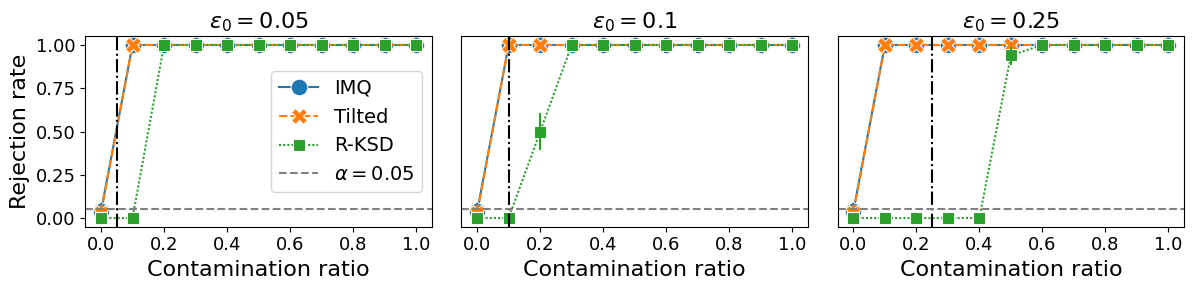

In [32]:
# _, axes = plt.subplots(ncols=len(eps0_ls), figsize=(4.5*len(eps0_ls), 2))
_, axes = plt.subplots(ncols=len(eps0_ls), figsize=(4*len(eps0_ls), 3))

for i, eps0 in enumerate(eps0_ls):
    plot_df = plot_df_ls[eps0]

    ax = axes[i]
    _ = sns.lineplot(ax=ax, data=plot_df, x="eps", y="rej", hue="method", style="method", markers=True, err_style="bars", markersize=12)
    ax.axvline(eps0, color="k", linestyle="-.")
    ax.axhline(0.05, color="grey", linestyle="--", label=r"$\alpha=0.05$")
    ax.set_xlabel("Contamination ratio", fontsize=16)
    ax.set_ylabel("Rejection rate", fontsize=16)
    ax.tick_params(axis="both", labelsize=13)
    ax.set_title(rf"$\epsilon_0={eps0}$", fontsize=16)
    if i > 0:
        ax.legend([],[], frameon=False)
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")

# lgd = axes[0].legend(bbox_to_anchor=(0.65, 1.11, 1, 0.2), loc="lower left", ncol=6, fontsize=12)
# plt.subplots_adjust(wspace=0.1)
# plt.savefig("../figs/robust/rbm.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")

axes[0].legend(fontsize=14, loc="center right")
plt.tight_layout()
# plt.savefig("../figs/robust/rbm.pdf")

# Samples

In [94]:
X_res = pickle.load(open(f"../data/rbm/X_res_n{n}_seed2024.pkl", "rb"))
score_res = pickle.load(open(f"../data/rbm/score_res_n{n}_seed2024.pkl", "rb"))
ol_res = pickle.load(open(f"../data/rbm/ol_res_n{n}_seed2024.pkl", "rb"))

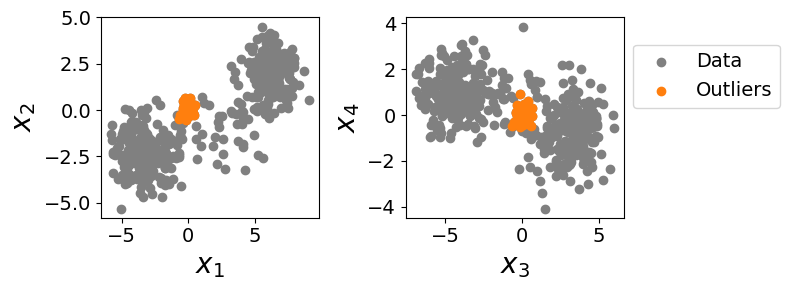

In [96]:
_, axes = plt.subplots(ncols=2, figsize=(4*2, 3))

eps = 0.1
for i, ax in enumerate(axes):
    X = X_res[eps][0]
    ol = ol_res[eps][0]
    
    ax.scatter(X[:, i*2], X[:, i*2+1], color="grey", label="Data")
    ax.scatter(ol[:, i*2], ol[:, i*2+1], color="C1", label="Outliers")
    ax.set_xlabel(rf"$x_{i*2+1}$", fontsize=20)
    ax.set_ylabel(rf"$x_{i*2+2}$", fontsize=20)
    ax.tick_params(axis="both", labelsize=14)

lgd = ax.legend(fontsize=14, bbox_to_anchor=(1., 0.5, 1, 0.2), loc="lower left")
plt.tight_layout()
# plt.savefig("../figs/robust/rbm_data.pdf", bbox_extra_artists=(lgd,))

In [28]:
ol.shape[0] / X.shape[0]

0.1

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

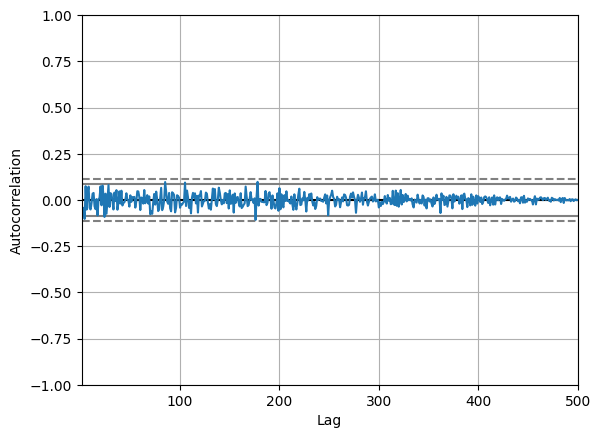

In [4]:
# pd.plotting.autocorrelation_plot(X[:, 0])

# Sampling cost

In [91]:
time_sample = pickle.load(open(f"../data/rbm/time_sample_n{n}_seed2024.pkl", "rb"))
time_test = np.array(res_stats[eps_ls[0]]["tilted_r_boot"]["time"])

In [92]:
time_x_mean = np.mean(time_sample)
time_test_mean = np.mean(time_test)

In [93]:
print(f"Time taken to sample {n} data: mean: {time_x_mean}; std: {time_sample.std()}")
print(f"Time taken to compute ksd: mean: {time_test_mean}; std: {time_test.std()}")

Time taken to sample 500 data: mean: 4.918643567562103; std: 0.03875155621594595
Time taken to compute ksd: mean: 0.861212649345398; std: 0.05883872426471401
